In [1]:
import pandas as pd
import nltk
import re
import random
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [2]:
baseline = "Baseline"
stem = "Stemmed"
lem = "Lemmatized"
bow = "Bag_of_Words"
tfidf = "TF_IDF"
random_state = 42
random.seed(random_state)
data_path = "./data/combined.csv"

# EDA

## Basics

In [3]:
df = pd.read_csv(data_path, low_memory=False)
print(df.isna().sum() / len(df) * 100)

overall            0.000000
verified           0.000000
reviewTime         0.000000
reviewerID         0.000000
asin               0.000000
style             50.710965
reviewerName       0.016280
reviewText         0.049506
summary            0.025620
unixReviewTime     0.000000
vote              84.972458
image             97.894193
dtype: float64


In [4]:
print(df.isna().sum())

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
style             380030
reviewerName         122
reviewText           371
summary              192
unixReviewTime         0
vote              636787
image             733623
dtype: int64


In [5]:
shpae = df.shape
print(df.isna().sum().sum() / (shpae[0] * shpae[1]) * 100)

19.47241852636673


In [6]:
df.head()

overall  verified   reviewTime      reviewerID        asin  \
0      5.0      True   09 1, 2016  A3CIUOJXQ5VDQ2  B0000530HU   
1      5.0      True  11 14, 2013  A3H7T87S984REU  B0000530HU   
2      1.0      True  08 18, 2013  A3J034YH7UG4KT  B0000530HU   
3      5.0     False   05 3, 2011  A2UEO5XR3598GI  B0000530HU   
4      5.0      True   05 6, 2011  A3SFRT223XXWF7  B00006L9LC   

                                               style     reviewerName  \
0  {'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...         Shelly F   
1  {'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...     houserules18   
2  {'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...             Adam   
3  {'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...           Rich K   
4                          {'Size:': ' 200ml/6.7oz'}  C. C. Christian   

                                          reviewText  \
0                   As advertised. Reasonably priced   
1  Like the oder and the feel when I put it on my...   
2  I bought this to smell nice after I shave.  Wh...   
3  HEY!! I am an Aqua Velva Man and absolutely lo...   
4  If you ever want to feel pampered by a shampoo...   

                                             summary  unixReviewTime vote  \
0                                         Five Stars      1472688000  NaN   
1                                  Good for the face      1384387200  NaN   
2                                       Smells awful      1376784000  NaN   
3  Truth is There IS Nothing Like an AQUA VELVA MAN.      1304380800   25   
4                                    Bvlgari Shampoo      1304640000    3   

  image  
0   NaN  
1   NaN  
2   NaN  
3   NaN  
4   NaN

In [7]:
df = df[["overall", "reviewText", "summary", "verified"]]

## Review Lenghts

In [8]:
df["reviewTextLength"] = list(map(lambda x: len(x.split()), df["reviewText"].astype(str).values))
df["summaryLength"] = list(map(lambda x: len(x.split()), df["summary"].astype(str).values))
df["reviewTextWithSummaryLength"] = df["reviewTextLength"] + df["summaryLength"]

In [9]:
df[["reviewTextLength", "summaryLength", "reviewTextWithSummaryLength"]].describe()

reviewTextLength  summaryLength  reviewTextWithSummaryLength
count     749404.000000  749404.000000                749404.000000
mean          42.184416       4.123271                    46.307687
std           83.203993       3.489392                    84.259299
min            0.000000       0.000000                     2.000000
25%            6.000000       2.000000                     8.000000
50%           19.000000       2.000000                    23.000000
75%           44.000000       5.000000                    50.000000
max         5118.000000      49.000000                  5125.000000

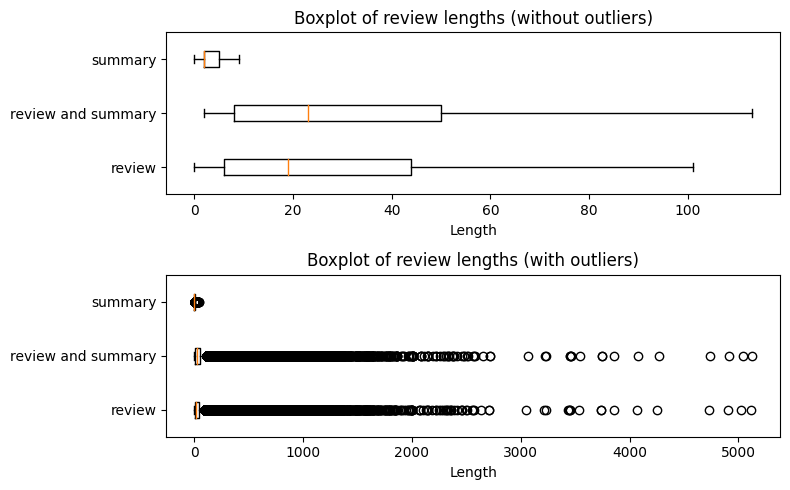

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5))
ax[0].boxplot(
    df[["reviewTextLength", "reviewTextWithSummaryLength", "summaryLength"]],
    vert=False,
    showfliers=False,
    labels=["review", "review and summary", "summary"],
)
ax[0].set_xlabel("Length")
ax[0].set_title("Boxplot of review lengths (without outliers)")
ax[1].boxplot(
    df[["reviewTextLength", "reviewTextWithSummaryLength", "summaryLength"]],
    vert=False,
    labels=["review", "review and summary", "summary"],
)
ax[1].set_xlabel("Length")
ax[1].set_title("Boxplot of review lengths (with outliers)")
plt.tight_layout()
plt.savefig("./results/review_length_boxplot.png")
plt.show()

In [11]:
massive_reviews = df[df["reviewTextLength"] > 3000]["reviewText"].values

In [12]:
print(f"number of review larger than 3000 words: {len(massive_reviews)}")

number of review larger than 3000 words: 17


In [13]:
print(massive_reviews[0].replace("\\n", "\n"))

As a person who's a great fan of Strats and who currently has 5 Standard Stratocasters in his arsenal, I thought it was time I wrote a review on these fine instruments.  Before I begin, let me say that not only have I been playing for over 30 years now (both on stage and in the studio), I've also done my own setups and repairs for MANY of those years, I've built my own "Partscasters" and I've even cut a body or two in my day. Further, out of my collection of nearly 30 guitars (electrics and acoustics) 12 of those are Strats (of various breed, vintage and model) and they have been my primary electric weapon of choice for the past 18+ years. . In other words, I do know a little something about guitars and particularly Strats.

I would also like to briefly add that this review is aimed towards younger and/or less experienced players or simply those new to the world of Fender Strats.  If you're like me and have been playing for more than a few years, chances are you already know what a "St

In [14]:
print(massive_reviews[1].replace("\\n", "\n"))

So you're thinking about buying one of these Griffin snare drums but wondering what kind of drum you get for $40? Who could blame you, the $40 price tag is double edged. On one hand at $40 your expectations are going to be pretty low. So low in fact you may just skip it figuring that you will just be throwing $40 out the window on a cheap drum. On the other, $40 is such a low price it is tempting to at least give it a shot and hope it will at least perform its required duty.

I'm with you on these points. I got the bug to buy a drum set after not having one for about 20 years. Why exactly I wound up buying several sets is baffling. Actually I bought 3 sets but 2 were missing snare drums. Thus my need to buy a snare drum or two. The issue was that though the sets seemed enticingly inexpensive, after buying missing hardware, drum heads, hoops, etc, I had more money than any reasonable person would find prudent into these "inexpensive" sets. Adding another $100 to $200 to each for a snare

In [15]:
print(massive_reviews[-1].replace("\\n", "\n"))

I bought the Cameo on a whim last x-mas. I had heard all the buzz about it, and wanted to try it out. Was it any better than my Cricut. At first, NO! You have to buy each cut off their website (if you bought the subscription it's actually not that bad, each design is $1 and if you max out your credit allotment, you get designs at a discounted price). There are some freebies too. I was a little intimidated by the unlimited options. Where do I go, what do I start making....?!?!?! Once I got the hang out of it and had a project lined up, it made it super easy to use and learn.

Major differences of the two:
Cricut mats are THE BEST! I use these mats in my silhouette - the firmness of the mats prevent it from slipping and sliding (which in the silhouette is THE. MOST. ANNOYING. THING. EVER.) Especially when you're down to 1 sheet of the paper you need to complete a project. Cricut mats are also less expensive than Silhouettes. Both mats are insanely sticky (too sticky) so I rub the mat on 

In [16]:
print(massive_reviews[-2].replace("\\n", "\n"))

Small update:  Nov. 4, 2017
As noted below, the internal supplied incandescent bulb is dull and dim.  The sewing machine suppliers don't seem to know it, but you can put in an LED.  You need a 12V T5 bulb.  This is the one I put in:
  "921-CWHP15-TAC 921 LED Bulb - 15 SMD LED Tower - Miniature Wdge Retrofit - Cool White"
It is much brighter and whiter and not as hot.  It casts funny shadows, but is till a major improvement over the supplied bulb.  The old bulb pulls out and you push this one in.

Updated March 16, 2017
I bought my MC6300P 17 months ago from Patchwork Angels in Endicott, NY. I recommend buying, like I did,  from a shop that can spend an hour or two showing you around the machine. And can help you when you have trouble.  There are lots of good machines around with various brands (Janome, Pfaff, Husquavarna/Viking, Baby-Lock, Bernina, Elna).  Probably each brand has a machine you'd like.  But whichever you get, you will like it the more if there is a local shop to help wi

In [17]:
large_reviews = df[df['reviewTextLength'] > 500]['reviewText'].values

In [18]:
print(f"{len(large_reviews)/len(df)*100}% of reviews are longer than 500 words long")

0.5080036936018489% of reviews are longer than 500 words long


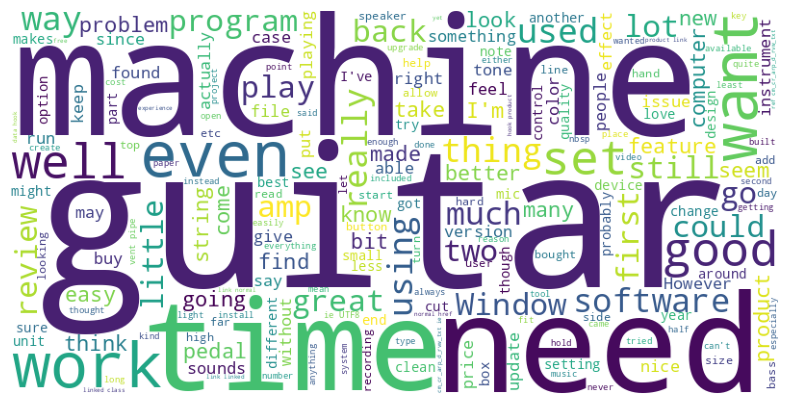

In [19]:
STOP_WORDS = set(stopwords.words("english"))
STOP_WORDS.update(["use", "one", "like", "get", "sound", "would", "also", "make"])


wordcloud = WordCloud(width=800, height=400, random_state=random_state, stopwords=STOP_WORDS, background_color='white').generate(
    " ".join(large_reviews)
)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("./results/wordcloud_large_reviews.png")
plt.show()

In [20]:
df = df[["overall", "reviewText", "summary", "verified"]]

In [21]:
print(df.isna().sum() / len(df) * 100)

overall       0.000000
reviewText    0.049506
summary       0.025620
verified      0.000000
dtype: float64


In [22]:
df = df.dropna()

In [23]:
print(df.isna().sum() / len(df) * 100)

overall       0.0
reviewText    0.0
summary       0.0
verified      0.0
dtype: float64


## Distributions

In [24]:
df["overall"].value_counts()

overall
5.0    553318
4.0    103923
3.0     47109
1.0     23557
2.0     20944
Name: count, dtype: int64

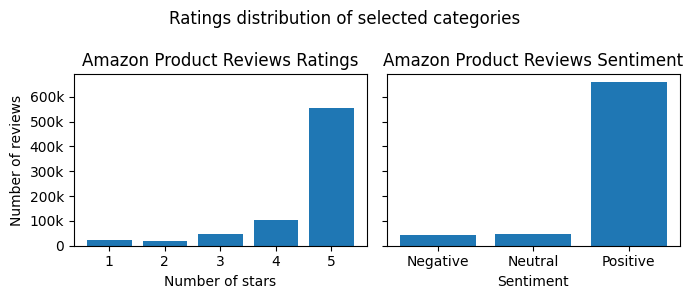

In [25]:
data = df["overall"].value_counts().sort_index().to_dict()
negative = data[1] + data[2]
neutral = data[3]
positive = data[4] + data[5]
sentiment_data = {"Negative": negative, "Neutral": neutral, "Positive": positive}

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7, 3))
ax[0].bar(data.keys(), data.values())
ax[0].set_xlabel('Number of stars')
ax[0].set_ylabel('Number of reviews')
ax[0].set_yticks([0, 100000, 200000, 300000, 400000, 500000, 600000, 700000],
                 ['0', '100k', '200k', '300k', '400k', '500k', '600k', '700k'])
ax[0].set_title('Amazon Product Reviews Ratings')
ax[1].bar(sentiment_data.keys(), sentiment_data.values())
ax[1].set_xlabel('Sentiment')
ax[1].set_title('Amazon Product Reviews Sentiment')
plt.suptitle("Ratings distribution of selected categories")
plt.tight_layout()
plt.savefig("./results/selected_categories_ratings_distribution.png")
plt.show()

In [26]:
df["sentiment"] = df["overall"].apply(lambda x: 1 if x > 3 else -1 if x < 3 else 0)
df["reviewTextWithSummary"] = df["summary"] + " " + df["reviewText"]
df.drop(["overall", "summary"], axis=1, inplace=True)
df.head()

reviewText  verified  sentiment  \
0                   As advertised. Reasonably priced      True          1   
1  Like the oder and the feel when I put it on my...      True          1   
2  I bought this to smell nice after I shave.  Wh...      True         -1   
3  HEY!! I am an Aqua Velva Man and absolutely lo...     False          1   
4  If you ever want to feel pampered by a shampoo...      True          1   

                               reviewTextWithSummary  
0        Five Stars As advertised. Reasonably priced  
1  Good for the face Like the oder and the feel w...  
2  Smells awful I bought this to smell nice after...  
3  Truth is There IS Nothing Like an AQUA VELVA M...  
4  Bvlgari Shampoo If you ever want to feel pampe...

In [27]:
df["sentiment"].value_counts()

sentiment
 1    657241
 0     47109
-1     44501
Name: count, dtype: int64

In [28]:
df.head()

reviewText  verified  sentiment  \
0                   As advertised. Reasonably priced      True          1   
1  Like the oder and the feel when I put it on my...      True          1   
2  I bought this to smell nice after I shave.  Wh...      True         -1   
3  HEY!! I am an Aqua Velva Man and absolutely lo...     False          1   
4  If you ever want to feel pampered by a shampoo...      True          1   

                               reviewTextWithSummary  
0        Five Stars As advertised. Reasonably priced  
1  Good for the face Like the oder and the feel w...  
2  Smells awful I bought this to smell nice after...  
3  Truth is There IS Nothing Like an AQUA VELVA M...  
4  Bvlgari Shampoo If you ever want to feel pampe...

## Transformations

In [29]:
STOP_WORDS = set(stopwords.words("english"))

In [30]:
def preprocess_text(sentence, stop, type_proc=None):
    words = []
    for word in sentence.lower().strip().split():

        word = re.sub("\d", "", word)
        word = re.sub("[^\w\s]", "", word)

        if word not in stop and word != "":
            words.append(preprocess_type(word, type_proc))

    return " ".join(words)

In [31]:
def preprocess_type(word, type_proc):
    if type_proc == baseline:
        return word
    elif type_proc == stem:
        return PorterStemmer().stem(word)
    elif type_proc == lem:
        return WordNetLemmatizer().lemmatize(word)
    else:
        raise ValueError("Invalid Preprocessing Type")

In [32]:
def check_preprocessing(proc, df):
    textcol = "reviewText"
    df[textcol] = df[textcol].apply(
        lambda x: preprocess_text(x, STOP_WORDS, proc)
    )
    textcol = "reviewTextWithSummary"
    df[textcol] = df[textcol].apply(
        lambda x: preprocess_text(x, STOP_WORDS, proc)
    )
    display(df.head())

In [33]:
display(df.head())
print("Original dataset")
check_preprocessing(baseline, df.head())
print("Removing stopwords only")
check_preprocessing(stem, df.head())
print("Removing stopwords and stemmed")
check_preprocessing(lem, df.head())
print("Removing stopwords and lemmatized")

reviewText  verified  sentiment  \
0                   As advertised. Reasonably priced      True          1   
1  Like the oder and the feel when I put it on my...      True          1   
2  I bought this to smell nice after I shave.  Wh...      True         -1   
3  HEY!! I am an Aqua Velva Man and absolutely lo...     False          1   
4  If you ever want to feel pampered by a shampoo...      True          1   

                               reviewTextWithSummary  
0        Five Stars As advertised. Reasonably priced  
1  Good for the face Like the oder and the feel w...  
2  Smells awful I bought this to smell nice after...  
3  Truth is There IS Nothing Like an AQUA VELVA M...  
4  Bvlgari Shampoo If you ever want to feel pampe...

Original dataset


reviewText  verified  sentiment  \
0                       advertised reasonably priced      True          1   
1  like oder feel put face tried brands reviews p...      True          1   
2  bought smell nice shave put smelled awful smel...      True         -1   
3  hey aqua velva man absolutely love stuff using...     False          1   
4  ever want feel pampered shampoo one one smells...      True          1   

                               reviewTextWithSummary  
0            five stars advertised reasonably priced  
1  good face like oder feel put face tried brands...  
2  smells awful bought smell nice shave put smell...  
3  truth nothing like aqua velva man hey aqua vel...  
4  bvlgari shampoo ever want feel pampered shampo...

Removing stopwords only


reviewText  verified  sentiment  \
0                              advertis reason price      True          1   
1  like oder feel put face tri brand review peopl...      True          1   
2  bought smell nice shave put smell aw smell lik...      True         -1   
3  hey aqua velva man absolut love stuff use year...     False          1   
4  ever want feel pamper shampoo one one smell li...      True          1   

                               reviewTextWithSummary  
0                    five star advertis reason price  
1  good face like oder feel put face tri brand re...  
2  smell aw bought smell nice shave put smell aw ...  
3  truth noth like aqua velva man hey aqua velva ...  
4  bvlgari shampoo ever want feel pamper shampoo ...

Removing stopwords and stemmed


reviewText  verified  sentiment  \
0                       advertised reasonably priced      True          1   
1  like oder feel put face tried brand review peo...      True          1   
2  bought smell nice shave put smelled awful smel...      True         -1   
3  hey aqua velva man absolutely love stuff using...     False          1   
4  ever want feel pampered shampoo one one smell ...      True          1   

                               reviewTextWithSummary  
0             five star advertised reasonably priced  
1  good face like oder feel put face tried brand ...  
2  smell awful bought smell nice shave put smelle...  
3  truth nothing like aqua velva man hey aqua vel...  
4  bvlgari shampoo ever want feel pampered shampo...

Removing stopwords and lemmatized


In [34]:
positive_text_raw = df[df["sentiment"] == 1]["reviewText"].values
negative_text_raw = df[df["sentiment"] == -1]["reviewText"].values
neutral_text_raw = df[df["sentiment"] == 0]["reviewText"].values
print("senitments")

positive_text_with_summary_raw = df[df["sentiment"] == 1][ "reviewTextWithSummary" ].values
negative_text_with_summary_raw = df[df["sentiment"] == -1][ "reviewTextWithSummary" ].values
neutral_text_with_summary_raw = df[df["sentiment"] == 0][ "reviewTextWithSummary" ].values
print("senitments with summary")

positive_text_baseline = [ preprocess_text(x, STOP_WORDS, baseline) for x in positive_text_raw ]
negative_text_baseline = [ preprocess_text(x, STOP_WORDS, baseline) for x in negative_text_raw ]
neutral_text_baseline = [ preprocess_text(x, STOP_WORDS, baseline) for x in neutral_text_raw ]
print("senitments baseline")

positive_text_with_summary_baseline = [ preprocess_text(x, STOP_WORDS, baseline) for x in positive_text_with_summary_raw ]
negative_text_with_summary_baseline = [ preprocess_text(x, STOP_WORDS, baseline) for x in negative_text_with_summary_raw ]
neutral_text_with_summary_baseline = [ preprocess_text(x, STOP_WORDS, baseline) for x in neutral_text_with_summary_raw ]
print("senitments with summary baseline")

positive_text_stem = [preprocess_text(x, STOP_WORDS, stem) for x in positive_text_raw]
negative_text_stem = [preprocess_text(x, STOP_WORDS, stem) for x in negative_text_raw]
neutral_text_stem = [preprocess_text(x, STOP_WORDS, stem) for x in neutral_text_raw]
print("senitments stemmed")

positive_text_with_summary_stem = [ preprocess_text(x, STOP_WORDS, stem) for x in positive_text_with_summary_raw ]
negative_text_with_summary_stem = [ preprocess_text(x, STOP_WORDS, stem) for x in negative_text_with_summary_raw ]
neutral_text_with_summary_stem = [ preprocess_text(x, STOP_WORDS, stem) for x in neutral_text_with_summary_raw ]
print("senitments with summary stemmed")

positive_text_lem = [preprocess_text(x, STOP_WORDS, lem) for x in positive_text_raw]
negative_text_lem = [preprocess_text(x, STOP_WORDS, lem) for x in negative_text_raw]
neutral_text_lem = [preprocess_text(x, STOP_WORDS, lem) for x in neutral_text_raw]
print("senitments lemmatized")

positive_text_with_summary_lem = [ preprocess_text(x, STOP_WORDS, lem) for x in positive_text_with_summary_raw ]
negative_text_with_summary_lem = [ preprocess_text(x, STOP_WORDS, lem) for x in negative_text_with_summary_raw ]
neutral_text_with_summary_lem = [ preprocess_text(x, STOP_WORDS, lem) for x in neutral_text_with_summary_raw ]
print("senitments with summary lemmatized")

senitments
senitments with summary
senitments baseline
senitments with summary baseline
senitments stemmed
senitments with summary stemmed
senitments lemmatized
senitments with summary lemmatized


In [35]:
texts = {
    "positive_text_raw": positive_text_raw,
    "negative_text_raw": negative_text_raw,
    "neutral_text_raw": neutral_text_raw,
    "positive_text_with_summary_raw": positive_text_with_summary_raw,
    "negative_text_with_summary_raw": negative_text_with_summary_raw,
    "neutral_text_with_summary_raw": neutral_text_with_summary_raw,
    "positive_text_baseline": positive_text_baseline,
    "negative_text_baseline": negative_text_baseline,
    "neutral_text_baseline": neutral_text_baseline,
    "positive_text_with_summary_baseline": positive_text_with_summary_baseline,
    "negative_text_with_summary_baseline": negative_text_with_summary_baseline,
    "neutral_text_with_summary_baseline": neutral_text_with_summary_baseline,
    "positive_text_stem": positive_text_stem,
    "negative_text_stem": negative_text_stem,
    "neutral_text_stem": neutral_text_stem,
    "positive_text_with_summary_stem": positive_text_with_summary_stem,
    "negative_text_with_summary_stem": negative_text_with_summary_stem,
    "neutral_text_with_summary_stem": neutral_text_with_summary_stem,
    "positive_text_lem": positive_text_lem,
    "negative_text_lem": negative_text_lem,
    "neutral_text_lem": neutral_text_lem,
    "positive_text_with_summary_lem": positive_text_with_summary_lem,
    "negative_text_with_summary_lem": negative_text_with_summary_lem,
    "neutral_text_with_summary_lem": neutral_text_with_summary_lem,
}

## Visualizations

In [36]:
def plot_word_cloud_subplots(pos, neg, neu, title):
    fig, ax = plt.subplots(1, 3, figsize=(9, 3.5), sharex=True)
    for i, text in enumerate([pos, neg, neu]):
        wordcloud = WordCloud(width=300, height=300, random_state=random_state, background_color='white').generate(
            text
        )
        ax[i].imshow(wordcloud, interpolation="bilinear")
        ax[i].axis("off")
        ax[i].set_title(["Positive", "Negative", "Neutral"][i])
    plt.suptitle(title)
    plt.tight_layout()
    plt.axis("off")
    plt.savefig(f"./results/{title}.png".replace(" ", "_"))
    plt.show()



In [37]:
def plot_top_words_count_subplots(pos, neg, neu, title, n=10):
    fig, ax = plt.subplots(1, 3, figsize=(9, 3.5), sharex=True)
    for i, text in enumerate([pos, neg, neu]):
        words = text.split()
        words = [word for word in words if word not in STOP_WORDS]
        words = pd.Series(words).value_counts(normalize=True).head(n) * 100
        ax[i].set_title(["Positive", "Negative", "Neutral"][i])
        ax[i].set_xlabel("Percentage")
        sns.barplot(x=words.values, y=words.index, ax=ax[i])
    ax[0].set_ylabel("Words")
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(f"./results/{title}.png".replace(" ", "_"))
    plt.show()

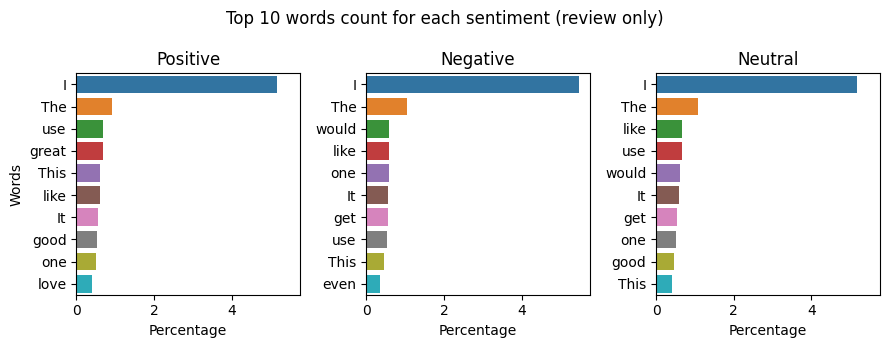

In [38]:
positive_text = " ".join(positive_text_raw)
negative_text = " ".join(negative_text_raw)
neutral_text = " ".join(neutral_text_raw)
plot_top_words_count_subplots(
    positive_text,
    negative_text,
    neutral_text,
    "Top 10 words count for each sentiment (review only)",
)

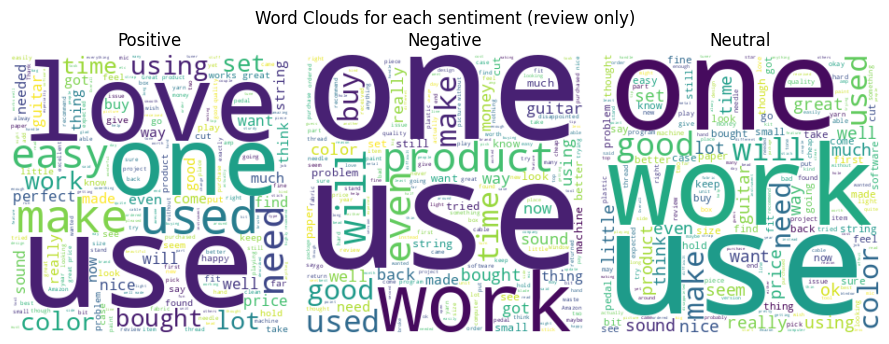

In [39]:
plot_word_cloud_subplots(positive_text, negative_text, neutral_text, "Word Clouds for each sentiment (review only)")

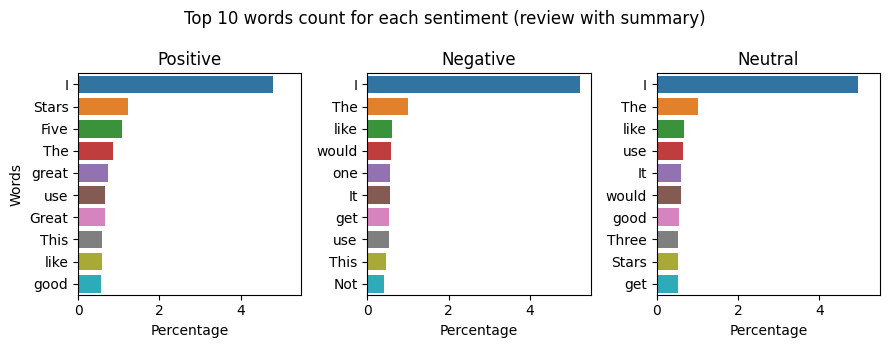

In [40]:
positive_text = " ".join(positive_text_with_summary_raw)
negative_text = " ".join(negative_text_with_summary_raw)
neutral_text = " ".join(neutral_text_with_summary_raw)
plot_top_words_count_subplots(
    positive_text,
    negative_text,
    neutral_text,
    "Top 10 words count for each sentiment (review with summary)",
)

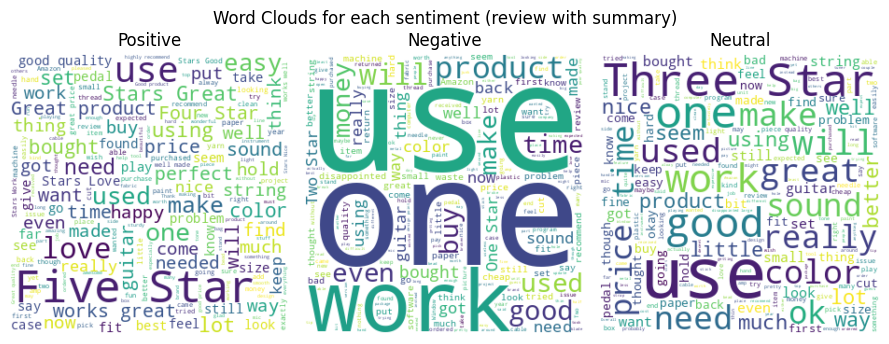

In [41]:
plot_word_cloud_subplots(positive_text, negative_text, neutral_text, "Word Clouds for each sentiment (review with summary)")

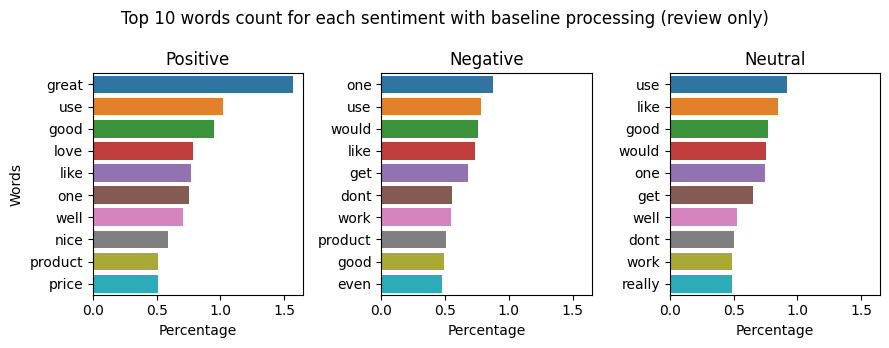

In [42]:
positive_text = " ".join(positive_text_baseline)
negative_text = " ".join(negative_text_baseline)
neutral_text = " ".join(neutral_text_baseline)
plot_top_words_count_subplots(
    positive_text,
    negative_text,
    neutral_text,
    "Top 10 words count for each sentiment with baseline processing (review only)",
)

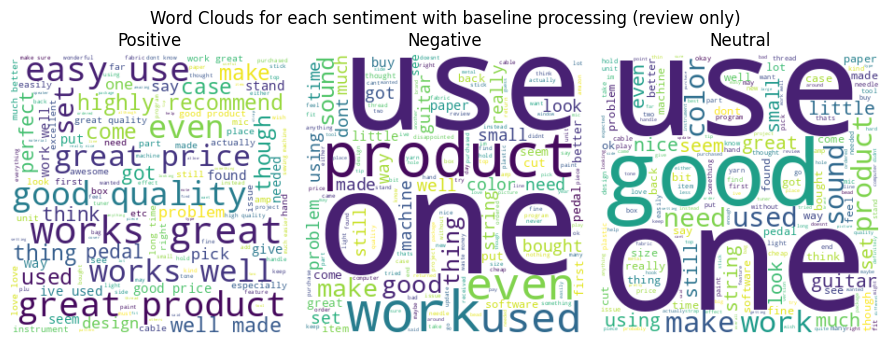

In [43]:
plot_word_cloud_subplots(positive_text, negative_text, neutral_text, "Word Clouds for each sentiment with baseline processing (review only)")

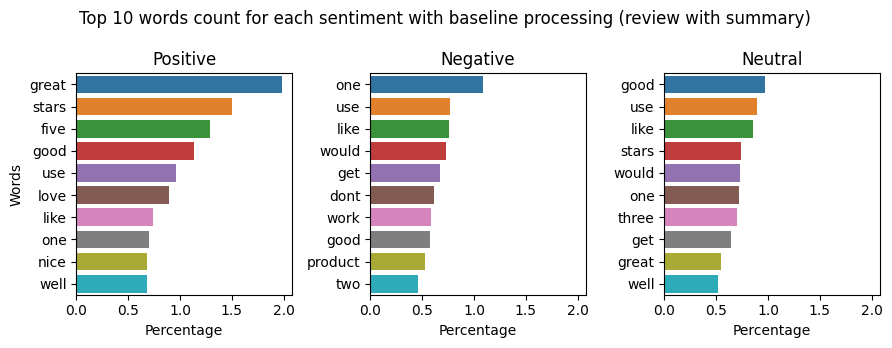

In [44]:
positive_text = " ".join(positive_text_with_summary_baseline)
negative_text = " ".join(negative_text_with_summary_baseline)
neutral_text = " ".join(neutral_text_with_summary_baseline)
plot_top_words_count_subplots(
    positive_text,
    negative_text,
    neutral_text,
    "Top 10 words count for each sentiment with baseline processing (review with summary)",
)

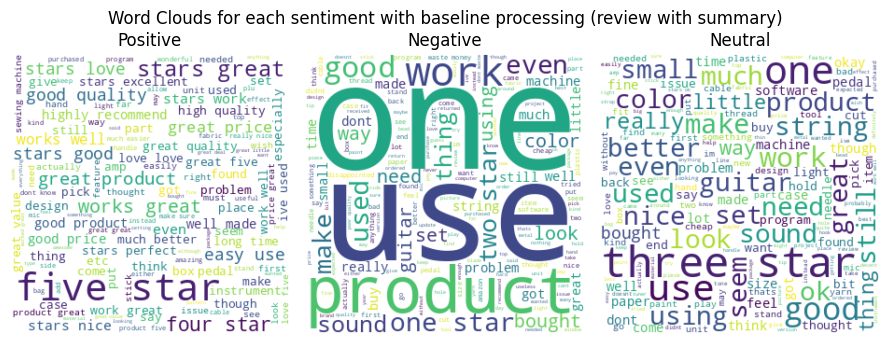

In [45]:
plot_word_cloud_subplots(positive_text, negative_text, neutral_text, "Word Clouds for each sentiment with baseline processing (review with summary)")

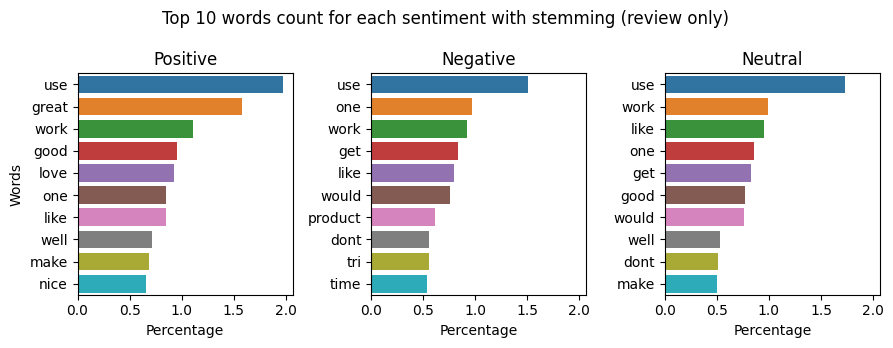

In [46]:
positive_text = " ".join(positive_text_stem)
negative_text = " ".join(negative_text_stem)
neutral_text = " ".join(neutral_text_stem)
plot_top_words_count_subplots(
    positive_text,
    negative_text,
    neutral_text,
    "Top 10 words count for each sentiment with stemming (review only)",
)

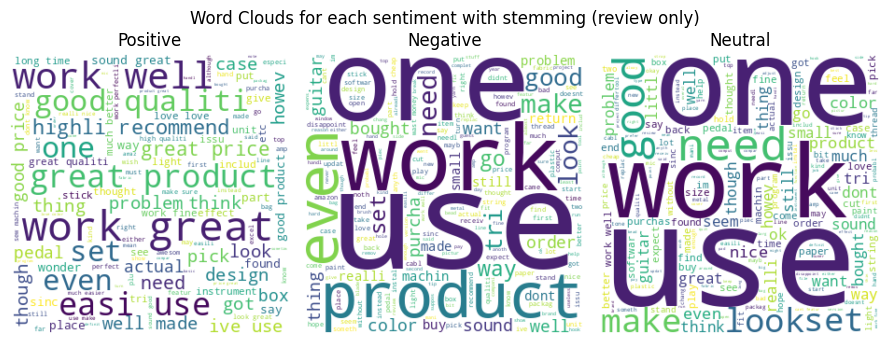

In [47]:
plot_word_cloud_subplots(positive_text, negative_text, neutral_text, "Word Clouds for each sentiment with stemming (review only)")

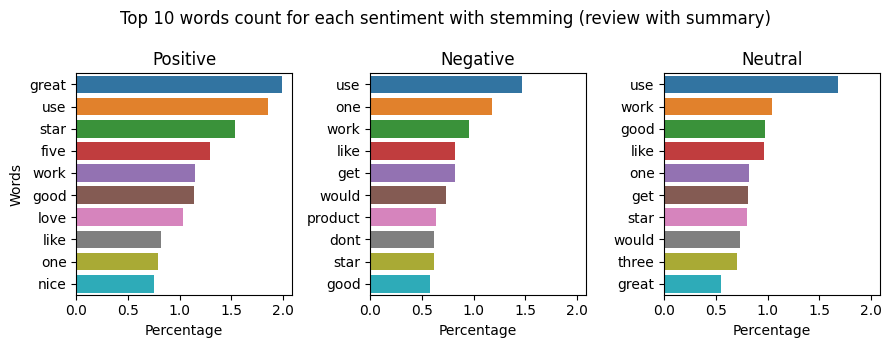

In [48]:
positive_text = " ".join(positive_text_with_summary_stem)
negative_text = " ".join(negative_text_with_summary_stem)
neutral_text = " ".join(neutral_text_with_summary_stem)
plot_top_words_count_subplots(
    positive_text,
    negative_text,
    neutral_text,
    "Top 10 words count for each sentiment with stemming (review with summary)",
)

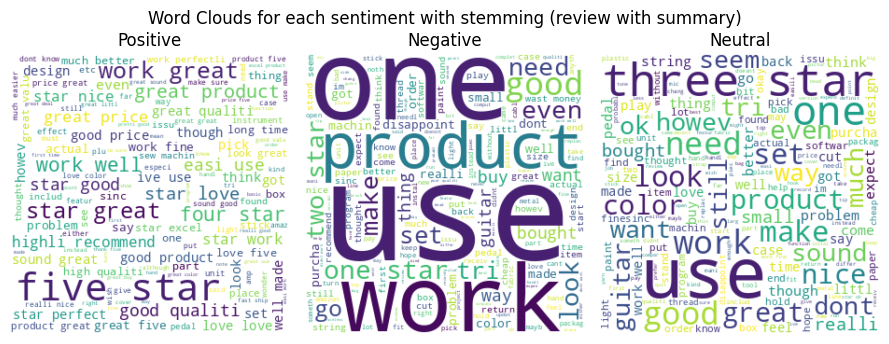

In [49]:
plot_word_cloud_subplots(positive_text, negative_text, neutral_text, "Word Clouds for each sentiment with stemming (review with summary)")

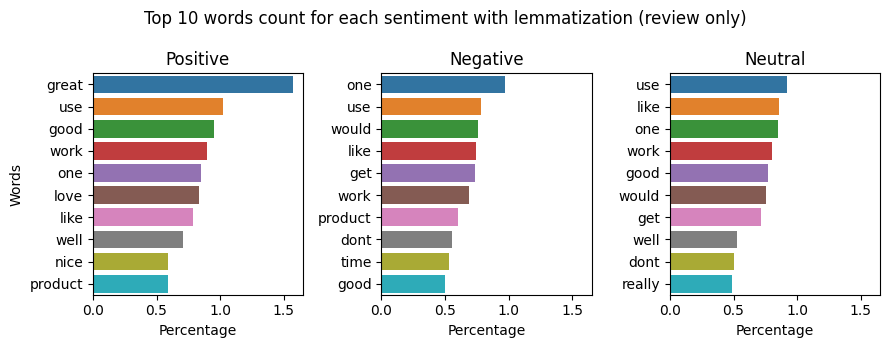

In [50]:
positive_text = " ".join(positive_text_lem)
negative_text = " ".join(negative_text_lem)
neutral_text = " ".join(neutral_text_lem)
plot_top_words_count_subplots(
    positive_text,
    negative_text,
    neutral_text,
    "Top 10 words count for each sentiment with lemmatization (review only)",
)

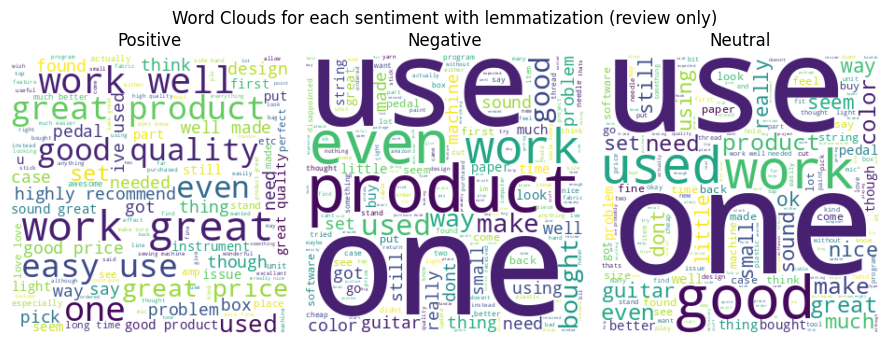

In [51]:
plot_word_cloud_subplots(positive_text, negative_text, neutral_text, "Word Clouds for each sentiment with lemmatization (review only)")

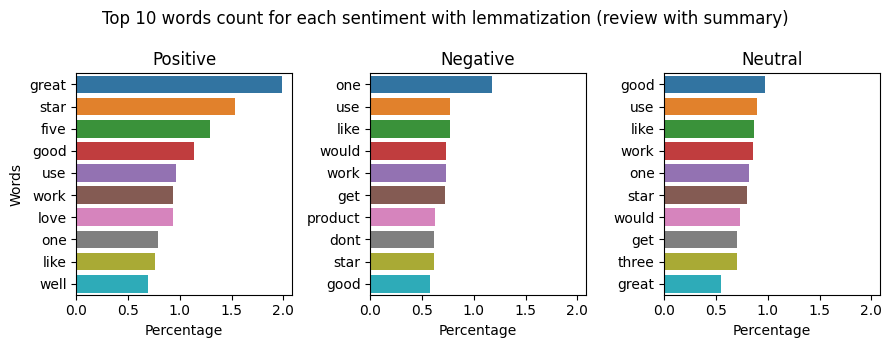

In [52]:
positive_text = " ".join(positive_text_with_summary_lem)
negative_text = " ".join(negative_text_with_summary_lem)
neutral_text = " ".join(neutral_text_with_summary_lem)
plot_top_words_count_subplots(
    positive_text,
    negative_text,
    neutral_text,
    "Top 10 words count for each sentiment with lemmatization (review with summary)",
)

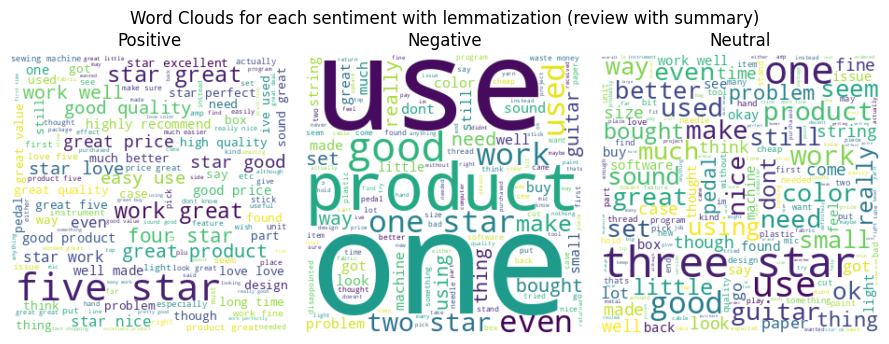

In [53]:
plot_word_cloud_subplots(positive_text, negative_text, neutral_text, "Word Clouds for each sentiment with lemmatization (review with summary)")